<a href="https://colab.research.google.com/github/SarraBenHamad/CarPricingPrediction/blob/main/car_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading data...

Analyzing raw data...


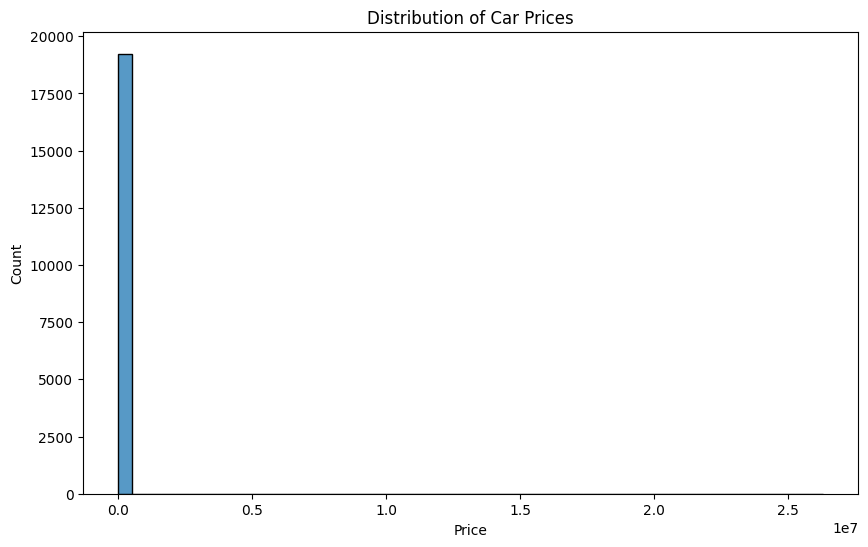

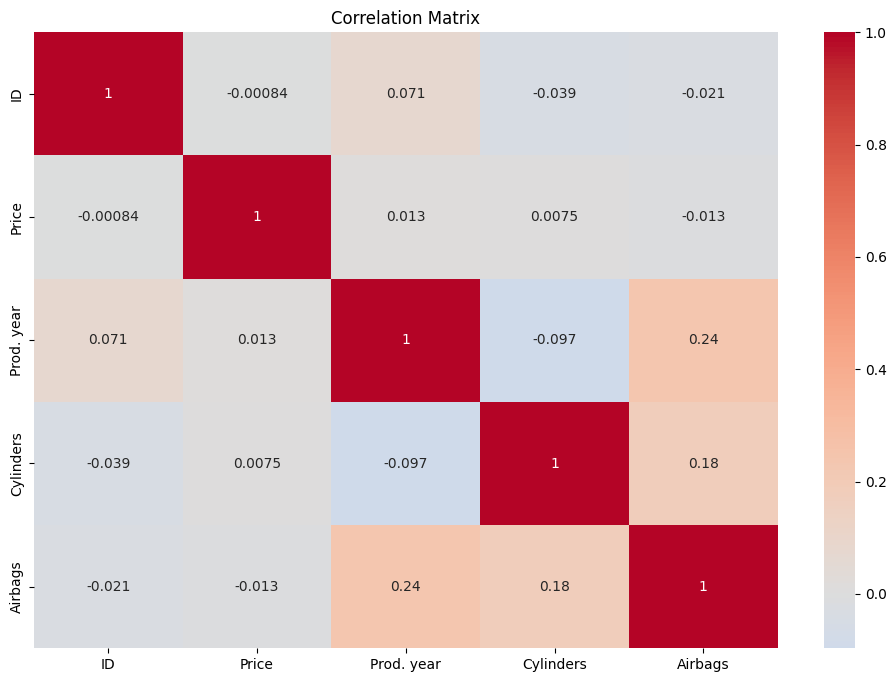


Cleaning data...

Removing outliers...

Preparing data for modeling...

Training model...


<ipython-input-25-f7417e40de4c>:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean = df_clean[z_scores < n_std]
<ipython-input-25-f7417e40de4c>:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean = df_clean[z_scores < n_std]
<ipython-input-25-f7417e40de4c>:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean = df_clean[z_scores < n_std]


Mean Cross-Validation MSE: 200959212.70

Model Performance:
Mean Squared Error: 181,983,929.80
Root Mean Squared Error: 13,490.14
R² Score: 0.2327

Top 10 Most Important Features:
          Feature  Coefficient
1      Prod. year  6788.296037
13        Airbags -3762.604402
5   Engine volume  3423.735929
8   Gear box type  3208.112576
2        Category -1864.363957
7       Cylinders -1518.913898
9    Drive wheels  1229.086678
11          Wheel -1219.151637
0            Levy  1118.502752
4       Fuel type  -940.779372


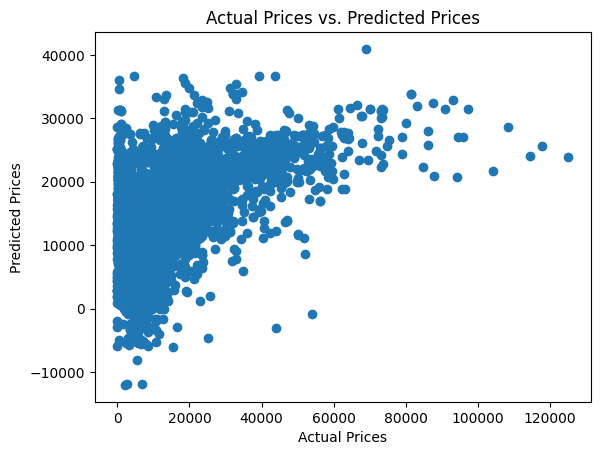

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

def clean_data(df):
    """Clean and prepare the data for modeling."""
    df = df.copy()

    # Clean mileage (remove 'km' and convert to numeric)
    df['Mileage'] = df['Mileage'].str.replace(' km', '').astype(float)

    # Clean Engine volume (ensure numeric)
    df['Engine volume'] = pd.to_numeric(df['Engine volume'], errors='coerce')

    # Clean Doors (extract numeric value)
    df['Doors'] = df['Doors'].str.extract('(\d+)').astype(float)

    # Handle missing values in Levy (replace '-' with NaN)
    df['Levy'] = pd.to_numeric(df['Levy'].replace('-', np.nan), errors='coerce')

    return df

def remove_outliers(df, columns, n_std=3):
    """Remove outliers based on z-score."""
    df_clean = df.copy()
    for column in columns:
        if df[column].dtype in ['int64', 'float64']:
            z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
            df_clean = df_clean[z_scores < n_std]
    return df_clean

def prepare_data(df):
    """Encode categorical variables, scale features, and handle missing values."""
    df = df.copy()

    # Drop the ID column
    df = df.drop('ID', axis=1)

    # Create manufacturer_model combined feature
    df['Manufacturer_Model'] = df['Manufacturer'] + '_' + df['Model']

    # List of categorical columns
    categorical_columns = ['Manufacturer_Model', 'Category', 'Leather interior',
                         'Fuel type', 'Gear box type', 'Drive wheels', 'Wheel', 'Color']

    # Initialize label encoders for each categorical column
    label_encoders = {}
    for column in categorical_columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column].astype(str))

    # Drop original Manufacturer and Model columns
    df = df.drop(['Manufacturer', 'Model'], axis=1)

    # Handle missing values in numeric columns
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

    # Scale numeric features
    scaler = StandardScaler()
    numeric_columns = df.columns.difference(['Price'])
    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

    return df, label_encoders, scaler

def analyze_data(df):
    """Analyze and plot data distributions."""
    # Distribution of price
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Price'], bins=50)
    plt.title('Distribution of Car Prices')
    plt.show()

    # Correlation matrix for numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    correlation_matrix = df[numeric_cols].corr()

    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix')
    plt.show()

def train_model(df):
    """Train the linear regression model with cross-validation."""
    # Separate features and target
    X = df.drop('Price', axis=1)
    y = df['Price']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create the linear regression model
    model = LinearRegression()

    # Train the model
    model.fit(X_train, y_train)

    # Evaluate with cross-validation (this gives us a better estimate of the model's performance)
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    mean_cv_score = np.mean(cv_scores)
    print(f"Mean Cross-Validation MSE: {-mean_cv_score:.2f}")

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return model, X_train, X_test, y_train, y_test, y_pred, mse, r2

def main():
    # Read the data
    print("Loading data...")
    df = pd.read_csv('car_price_prediction.csv')

    print("\nAnalyzing raw data...")
    analyze_data(df)

    print("\nCleaning data...")
    df_cleaned = clean_data(df)

    print("\nRemoving outliers...")
    numeric_columns = ['Price', 'Mileage', 'Engine volume', 'Prod. year']
    df_no_outliers = remove_outliers(df_cleaned, numeric_columns)

    print("\nPreparing data for modeling...")
    df_processed, label_encoders, scaler = prepare_data(df_no_outliers)

    print("\nTraining model...")
    model, X_train, X_test, y_train, y_test, y_pred, mse, r2 = train_model(df_processed)

    # Print results
    print("\nModel Performance:")
    print(f"Mean Squared Error: {mse:,.2f}")
    print(f"Root Mean Squared Error: {np.sqrt(mse):,.2f}")
    print(f"R² Score: {r2:.4f}")

    print("\nTop 10 Most Important Features:")
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': model.coef_
    }).sort_values(by='Coefficient', key=abs, ascending=False)
    print(feature_importance.head(10))

    plt.scatter(y_test, y_pred)
    plt.xlabel("Actual Prices")
    plt.ylabel("Predicted Prices")
    plt.title("Actual Prices vs. Predicted Prices")
    plt.show()

if __name__ == "__main__":
    main()
